    In this dataset, main aim is classifying if a patient has a heart disease or not according to various personal and diagnostic variables. It is not a very large dataset, consisting only about 303 patient data. I will use various classification algorithms to get a generalization score from that dataset. I will use a nested-CV scheme for getting the accuracy and roc-auc scores from the model trained.

In [4]:
#importing libraries that will be required initially. Timeit will let me record the training time and warnings library is for
#filtering some of the warnings will occur at the spyder console during training process.
import pandas as pd
import numpy as np
import warnings
import timeit
# set option is the setting for spyder console, to be able to see all available columns and analysis of them
pd.set_option('display.max_columns',25)
start_time = timeit.default_timer()
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
    heart = pd.read_csv(r'C:\Users\ali.kilinc\Desktop\Heart Disease Classification\heart.csv', index_col= False)

In [12]:
#Initial analyis of data, columns and statistical summary. 
print(heart.info())
print(heart.describe())
print(heart.columns)
print(heart.head(5))
print(heart.dtypes)
#These columns are known to be categories initially. But code recognized them as int or float. Below code makes the conversion
for col in ['sex','cp','fbs','restecg','exang','slope','thal']:
    heart[col] = heart[col].astype('object')

#There is not any null data in dataset. So we wont need any imputation method.
#If it was needed, Imputation would be inside training pipeline or CV pipeline, in order to eliminate "Data Leakage" problems. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null object
cp          303 non-null object
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null object
restecg     303 non-null object
thalach     303 non-null int64
exang       303 non-null object
oldpeak     303 non-null float64
slope       303 non-null object
ca          303 non-null int64
thal        303 non-null object
target      303 non-null int64
dtypes: float64(1), int64(6), object(7)
memory usage: 33.2+ KB
None
              age    trestbps        chol     thalach     oldpeak          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337  131.623762  246.264026  149.646865    1.039604    0.729373   
std      9.082101   17.538143   51.830751   22.905161    1.161075    1.022606   
min     29.000000   94.000000  126.000000   71.000000    0.0

In [10]:
#Dataset is divided into input and output sets
X = heart.iloc[:, :-1]
xcol = heart.columns[:-1]
df_x = pd.DataFrame(X, columns = xcol)

Y = heart.iloc[:, 13:]
ycol = heart.columns[13:]
df_y = pd.DataFrame(Y, columns = ycol)

In [14]:
#columns are investigated for being fixed and empty. If there is any, they will not be included in analysis
#Empty and fixed columns will not contribute to training process, whereas they will decrease the efficiency

num_cols = list(df_x._get_numeric_data().columns)

fix_cols = []
for col in df_x.columns:
    if df_x[col].nunique() == 1:
        fix_cols.append(col)
    else:
        pass

emp_cols = []
for col in df_x.columns:
    if df_x[col].count() > 0:
        pass
    else:
        emp_cols.append(col)

cat_cols = list(set(df_x.columns) - set(num_cols) - set(emp_cols) - set(fix_cols))
num_cols = list(set(num_cols) - set(fix_cols) - set(emp_cols))
print(num_cols)
print(cat_cols)
print(emp_cols)
print(fix_cols)

df_x.drop(list(emp_cols+fix_cols))

['chol', 'oldpeak', 'thalach', 'ca', 'trestbps', 'age']
['exang', 'thal', 'slope', 'sex', 'restecg', 'fbs', 'cp']
[]
[]


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2


In [13]:
print(df_x[cat_cols].describe())
print(df_x[num_cols].describe())
print(df_x.info())

        exang  thal  slope  sex  restecg  fbs   cp
count     303   303    303  303      303  303  303
unique      2     4      3    2        3    2    4
top         0     2      2    1        1    0    0
freq      204   166    142  207      152  258  143
             chol     oldpeak     thalach          ca    trestbps         age
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000
mean   246.264026    1.039604  149.646865    0.729373  131.623762   54.366337
std     51.830751    1.161075   22.905161    1.022606   17.538143    9.082101
min    126.000000    0.000000   71.000000    0.000000   94.000000   29.000000
25%    211.000000    0.000000  133.500000    0.000000  120.000000   47.500000
50%    240.000000    0.800000  153.000000    0.000000  130.000000   55.000000
75%    274.500000    1.600000  166.000000    1.000000  140.000000   61.000000
max    564.000000    6.200000  202.000000    4.000000  200.000000   77.000000
<class 'pandas.core.frame.DataFrame'>
Range

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')


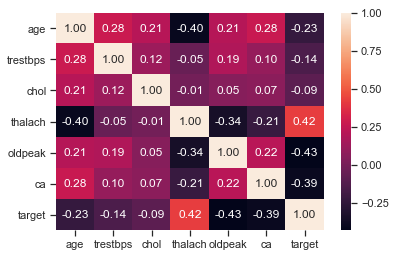

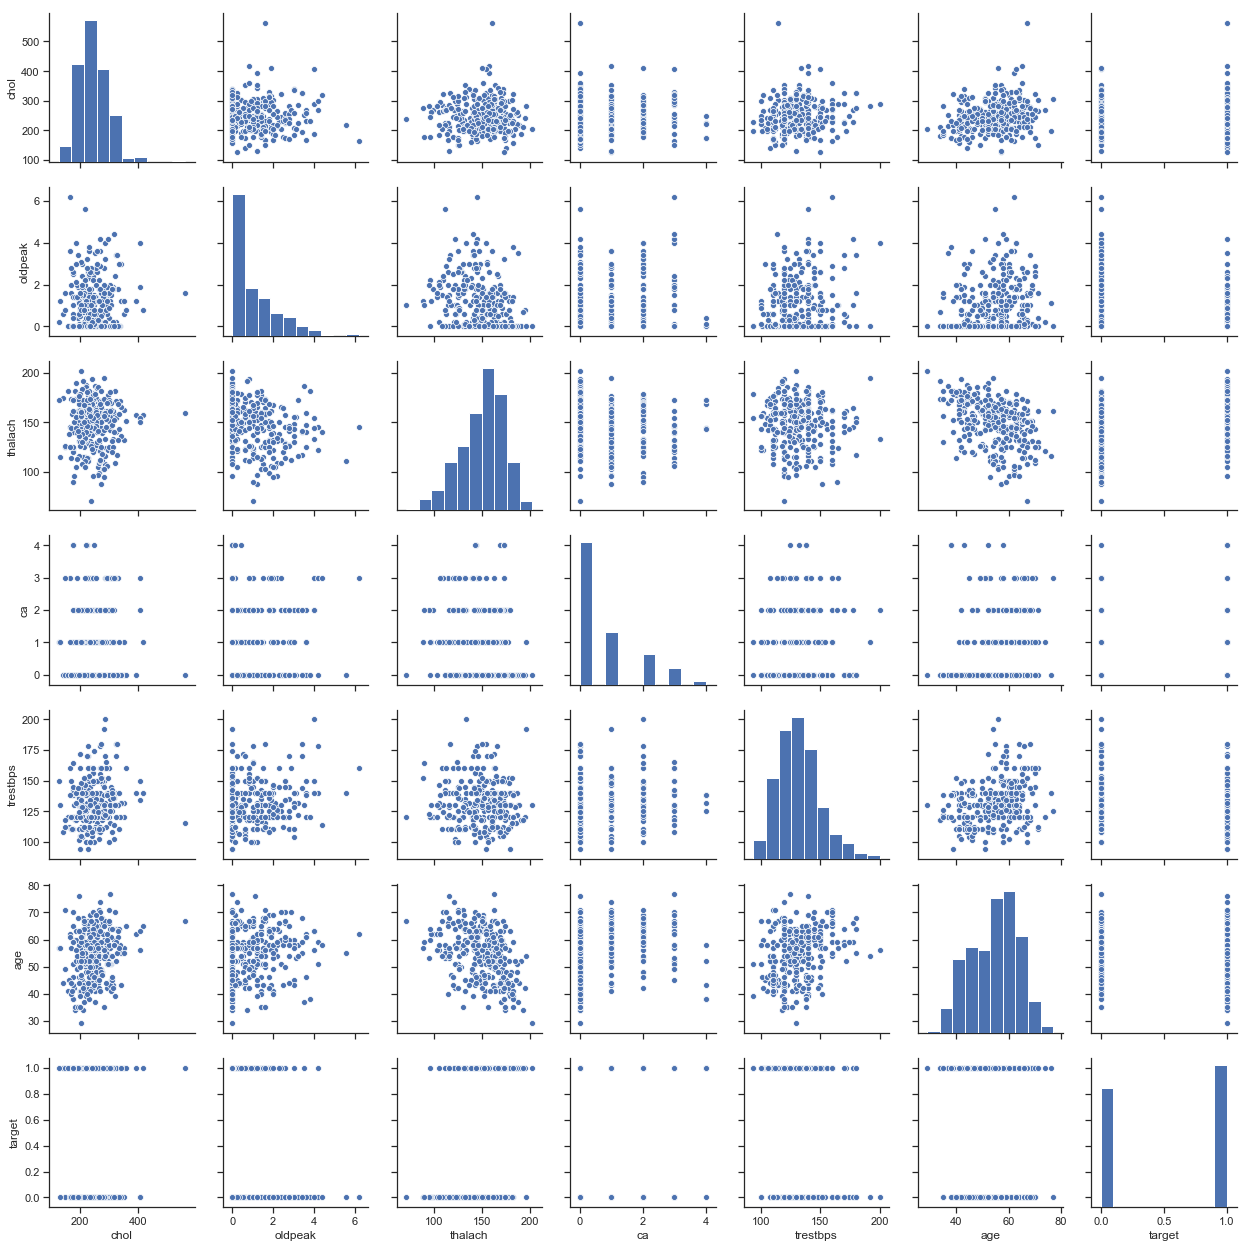

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
print(df_x.columns)
sns.set(style="ticks", color_codes=True)

sns.heatmap(heart.corr(), annot = True, fmt=".2f")
plt.show()

sns.pairplot(heart, vars = num_cols + list(df_y.columns))
plt.show()

#after looking at heatmap of the variables, there is not a clear multicollienarity problem amont numerical features. 
#We won't need to eliminate these from dataset inside training.

In [18]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, CategoricalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

#Required packages and libraries for the training process are imported here
#i will use a nested-cv scheme to find the generalization score of the model developed.
#Also i will use pipelines for handling preporocessing and grid_search together

Dataset have both categorical and numeric features. So, for preproessing, we have to handle both of these. As i stated before, preprocessing should be completed on training data, not on the whole dataset, in order to eliminate any data leakage.

I have to apply both numerical and categorical preprocessing and it is not applicable inside same pipeline. So, i will use a ColumnTransformer to combine 2 different pipelines as one. 

After combining these as preprocessing pipeline, i will also add grid_search inside the pipeline. Grid_search will search for best parameters inside each CV split, and give the best results according to best parameter set score. 

As an initial model i used a RandomForestClassifier, which is a Bagging algorithm consists of several DecisionTree algorithms.
It needs categorical data to be converted, so i used OneHotEncoding. Also, numerical data are standardized with a standardScaler. 

After getting a satisfactory regularization score from a model, it may be run on whole dataset with a single split, to finalize the model creation process and get a more detailed analysis of the training stage like ClassificationReport etc. 
    

In [23]:
rf = RandomForestClassifier(random_state = 23)

params = {
        'max_depth':np.linspace(1, 32, 4, endpoint=True),
        'n_estimators': [1, 2, 8, 32, 64, 200],
        'min_samples_split': np.linspace(0.1, 1.0, 5, endpoint=True),
        'min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True)
        }

numeric_pipe = make_pipeline(StandardScaler())
categoric_pipe = make_pipeline(OneHotEncoder(sparse = False, handle_unknown='ignore'))
preprocessor = ColumnTransformer(transformers = [('num',numeric_pipe, num_cols), ('cat',categoric_pipe,cat_cols)])
all_pipe = make_pipeline(preprocessor, rf)

grid_search = GridSearchCV(all_pipe, params, cv=3, verbose=0)


In [24]:
#I will use a stratified KFold CV method, in order to protect class distribution inside training dataset. 
cv = StratifiedKFold(n_splits = 5, random_state = 23, shuffle = False)

roc_auc = cross_val_score(grid_search, df_x, df_y.values.ravel(), scoring = 'roc_auc', cv=cv)
accuracy = cross_val_score(grid_search, df_x, df_y.values.ravel(), scoring = 'accuracy', cv=cv)

print("roc_auc = {}, accuracy = {}".format(np.mean(roc_auc),np.mean(accuracy)))
print("---%0.1f minutes---" %((timeit.default_timer()-start_time)/60))

C:\ProgramData\Anaconda3\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\ProgramData\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Prog

roc_auc = 0.9077681577681578, accuracy = 0.8283060109289618
---55.1 minutes---


C:\ProgramData\Anaconda3\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


There were many DepreciationWarning and DataConversionWarnings I should have neglected at the beginning like FutureWarning. So the output is not very clear.

It took 55 minutes for this dataset to be trained with my nested CV scheme and it has a 90% roc-auc with 82% accuracy. 
